#Allowing Import from Parent Directory

In [19]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#Importing Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da
import tools.visualisation as visual

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Loading and reshaping data

In [ ]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [3]:
train_full, test, model_data, satellite_data = loaddata.load_all_data(path_train, path_test, path_back, path_obs) 

In [18]:
# reducing the dataset due to RAM issues

In [4]:
train = train_full[0:300]

In [5]:
print(f"Train data before reshaping: {np.shape(train)}")
print(f"Test data before reshaping: {np.shape(test)}")
print(f"background data before reshaping: {np.shape(model_data)}")
print(f"observational data before reshaping: {np.shape(satellite_data)}")

Train data before reshaping: (300, 871, 913)
Test data before reshaping: (300, 871, 913)
background data before reshaping: (5, 871, 913)
observational data before reshaping: (5, 871, 913)


In [6]:
train_1D, test_1D, model_data_1D, satellite_data_1D = loaddata.reshape_all_datasets(train, test, model_data, satellite_data)

In [7]:
print(f"Train data after reshaping: {train_1D.shape}")
print(f"Test data after reshaping: {test_1D.shape}")
print(f"Model data after reshaping: {model_data_1D.shape}")
print(f"Observational data after reshaping: {satellite_data_1D.shape}")

Train data after reshaping: (300, 795223)
Test data after reshaping: (300, 795223)
Model data after reshaping: (5, 795223)
Observational data after reshaping: (5, 795223)


#CNN Autoencoder

Convolutional Neural Network (CNN) is composed of input layer, convolution layer, activation function, pooling layer and full connection layer, namely input (input layer) -conv (convolution layer) -RELu (activation function) -Pool (pooling layer) -FC (full connection layer).
It seems similar to what we have done in CAE autoencoder so we also tried this model to find a better mse.

1. The convolution layer computes the output of neurons that are connected to local regions or receptive fields in the input, each computing a dot product between their weights and a small receptive field to which they are connected to in the input volume. Each computation leads to extraction of a feature map from the input image

2. The objective of subsampling is to get an input representation by reducing its dimensions, which helps in reducing overfitting. One of the techniques of subsampling is max pooling.

3. The objective of the fully connected layer is to flatten the high-level features that are learned by convolutional layers and combining all the features. It passes the flattened output to the output layer where you use a softmax classifier or a sigmoid to predict the input class label.


In [8]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.Input(shape=(795223,)),
                                   keras.layers.Reshape((871,913,1)),
                                   keras.layers.Convolution2D(4,(10,10),activation='relu',padding='same'),
                                   keras.layers.MaxPooling2D((5,5),padding='same'),
                                   keras.layers.Convolution2D(8,(2,2),activation='relu',padding='same'),
                                   keras.layers.MaxPooling2D((3,3),padding='same'),
                                   keras.layers.Convolution2D(16,(3,3),activation='relu',padding='same'),
                                   keras.layers.MaxPooling2D((3,3),padding='same'),
                                   keras.layers.Convolution2D(32,(3,3),activation='relu',padding='same'),
                                   keras.layers.MaxPooling2D((2,2),padding='same'),
                                   keras.layers.Flatten(),
                                   keras.layers.Dense(30)])

decoder = keras.models.Sequential([keras.Input(shape=(30,)),
                                   keras.layers.Dense(110),
                                   keras.layers.Reshape((10,11,1)),
                                   keras.layers.Convolution2D(32,(2,2),activation='relu',padding='same'),
                                   keras.layers.UpSampling2D((2,2)),
                                   keras.layers.Convolution2D(16,(3,3),activation='relu',padding='same'),
                                   keras.layers.UpSampling2D((3,3)),
                                   keras.layers.Convolution2D(8,(3,3),activation='relu',padding='same'),
                                   keras.layers.UpSampling2D((3,3)),
                                   keras.layers.Convolution2D(4,(10,10),activation='relu',padding='same'),
                                   keras.layers.UpSampling2D((5,5)),
                                   keras.layers.Cropping2D(cropping=((29,0),(77,0)),data_format=None),
                                   keras.layers.Convolution2D(1,(10,10),activation='sigmoid',padding='same'),
                                   keras.layers.Flatten()])


autoencoder=keras.models.Sequential([encoder, decoder])
autoencoder.build(input_shape=(1,795223))
autoencoder.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['mse'])
print('Encoder:')
encoder.summary()
print('\nDencoder:')
decoder.summary()
print('\nAutoencoder:')
autoencoder.summary()

Encoder:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 871, 913, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 871, 913, 4)       404       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 183, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 183, 8)       136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 61, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 61, 16)

In [9]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [10]:
start = time.time()
history = autoencoder.fit(train_1D, 
                          train_1D, 
                          epochs=3, 
                          batch_size=8, 
                          verbose=2, 
                          validation_data = (test_1D, test_1D), 
                          shuffle = True, callbacks = [earlystopping])
time_ae = time.time() - start
print('Execution time: ', time_ae)

Epoch 1/3
38/38 - 259s - loss: 0.2909 - mse: 0.0957 - val_loss: 0.1564 - val_mse: 0.0539 - 259s/epoch - 7s/step
Epoch 2/3
38/38 - 253s - loss: 0.1710 - mse: 0.0598 - val_loss: 0.1385 - val_mse: 0.0483 - 253s/epoch - 7s/step
Epoch 3/3
38/38 - 255s - loss: 0.1599 - mse: 0.0561 - val_loss: 0.1312 - val_mse: 0.0456 - 255s/epoch - 7s/step
Execution time:  766.8620219230652


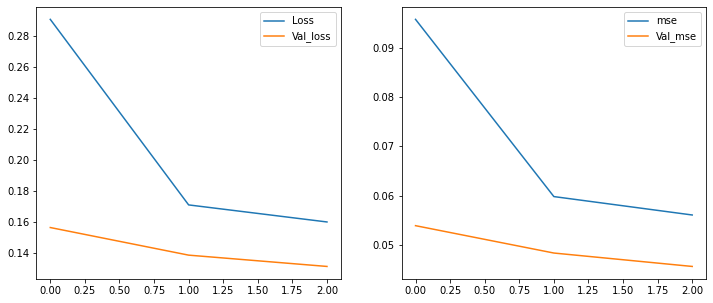

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].legend(['Loss', 'Val_loss'])
axes[1].plot(history.history['mse'])
axes[1].plot(history.history['val_mse'])
axes[1].legend(['mse', 'Val_mse'])

In [12]:
test_recovered = autoencoder.predict(test_1D)
mse_test = da.mse(test_1D, test_recovered)
print('mse: ', mse_test)

mse:  0.04562492107644386


#Data Assimilation - Kalman Filter (BLUE)

In [13]:
model_data_compr = encoder.predict(model_data_1D)
satellite_data_compr = encoder.predict(satellite_data_1D)

latent_space = satellite_data_compr.shape[1]
nNodes = latent_space  # latent_space is the size of the compressed variables or number of principal components used
I = np.identity(nNodes)
R = np.cov(satellite_data_compr.T)
H = I 
B = 0.001 * I

In [14]:
## Performing data assimilation
updated_data_array = da.assimilate(B, H, R, model_data_compr, satellite_data_compr)

## Printing MSE in latent space
mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
print('MSE before assimilation in latent space: ', mse_before_DA )
print('MSE after assimilation in latent space: ', mse_after_DA)

## Printing MSE in Physical space space
updated_data_recon = decoder.predict(updated_data_array)
mse_before_DA_physical = da.mse(satellite_data_1D, model_data_1D)
mse_after_DA_physical = da.mse(satellite_data_1D, updated_data_recon)

print('MSE before assimilation in physical space: ', mse_before_DA_physical)
print('MSE after assimilation in physical space: ', mse_after_DA_physical)

MSE before assimilation in latent space:  2.2674706
MSE after assimilation in latent space:  1.8236891496834948
MSE before assimilation in physical space:  0.1191695914227833
MSE after assimilation in physical space:  0.09038456877522648


#Visualising Results 

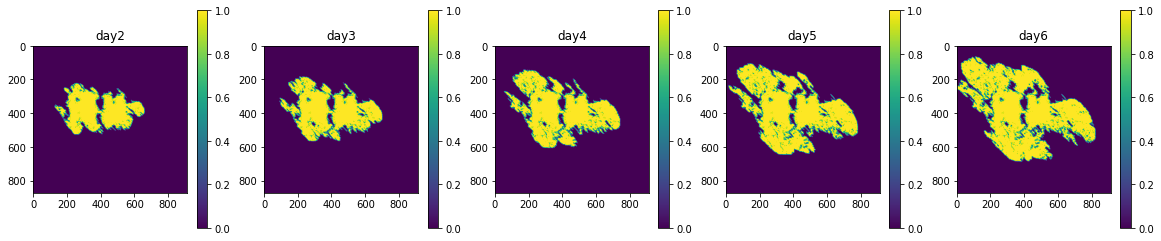

In [15]:
# Plot model data
visual.plot_data(model_data)

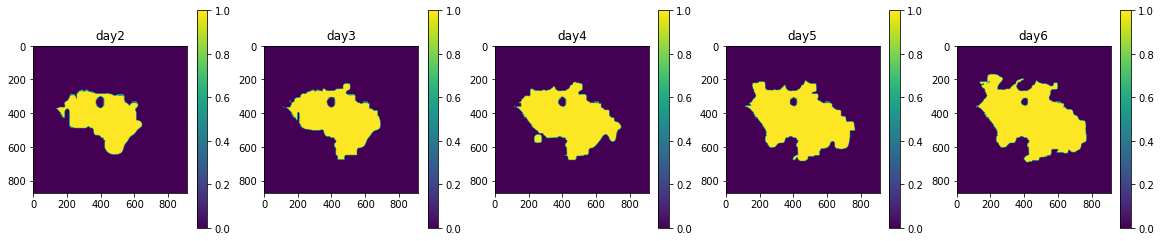

In [16]:
# Plot satellite data 
visual.plot_data(satellite_data)

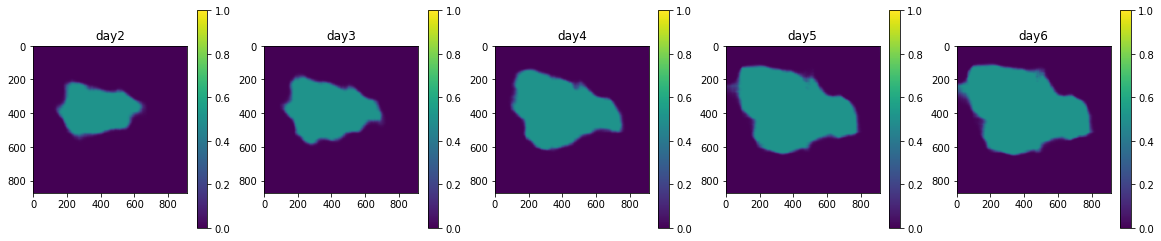

In [17]:
# Plot reconstructed model
updated_data_recon = np.reshape(updated_data_recon, (5, 871, 913))
visual.plot_data(updated_data_recon)